In [50]:
#
import numpy as np 
import pandas as pd 
import random

# folder
import os
import glob

# image
from PIL import Image

# visu
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [51]:
categories = ["NORMAL", "PNEUMONIA"]
datasets = ["train", "test", "val"]

In [52]:
#glob.glob('C:\\Users\\김주빈\\project\\Damion\\project\\Chest X-Ray Images (Pneumonia)\\chest_xray\\*')

In [53]:
%%time

widths = []
heights = []

for set_ in datasets:
    for cat in categories:
        filelist = glob.glob('C:\\Users\\김주빈\\chest_xray\\'+ set_ + '/' + cat + '/*.jpeg')
        widths.extend([Image.open(fname).size[0] for fname in filelist])
        heights.extend([Image.open(fname).size[1] for fname in filelist])

images_size = pd.DataFrame({"widths": widths, "heights": heights})
        
print("Average image width: " + f'{images_size["widths"].mean():.2f}')
print("Average image height: " + f'{images_size["heights"].mean():.2f}')

Average image width: 1327.88
Average image height: 970.69
Wall time: 2.26 s


In [35]:
im_width = int(images_size["widths"].mean()/10)
im_height = int(images_size["heights"].mean()/10)
print("image width: " + str(im_width))
print("image height: " + str(im_height))

image width: 132
image height: 97


In [54]:
%%time

data = []
target = []

for set_ in datasets:
    for cat in categories:
        filelist = glob.glob('C:\\Users\\김주빈\\chest_xray\\'+ set_ + '/' + cat + '/*.jpeg')
        target.extend([cat for _ in filelist])
        data.extend([np.array(Image.open(fname).convert('L').resize((im_width, im_height))) for fname in filelist])
#
data_array = np.stack(data, axis=0)

Wall time: 51.8 s


In [43]:
print(data_array.shape)

(5856, 97, 132)


In [40]:
pd.concat([pd.DataFrame(pd.DataFrame({"target" : target}).value_counts()).rename(columns={0:"count"}),
           pd.DataFrame(pd.DataFrame(target).value_counts()*100/len(target)).applymap(round).rename(columns={0:"%"})], axis=1)

,count,%
target,,
PNEUMONIA,4273,73
NORMAL,1583,27


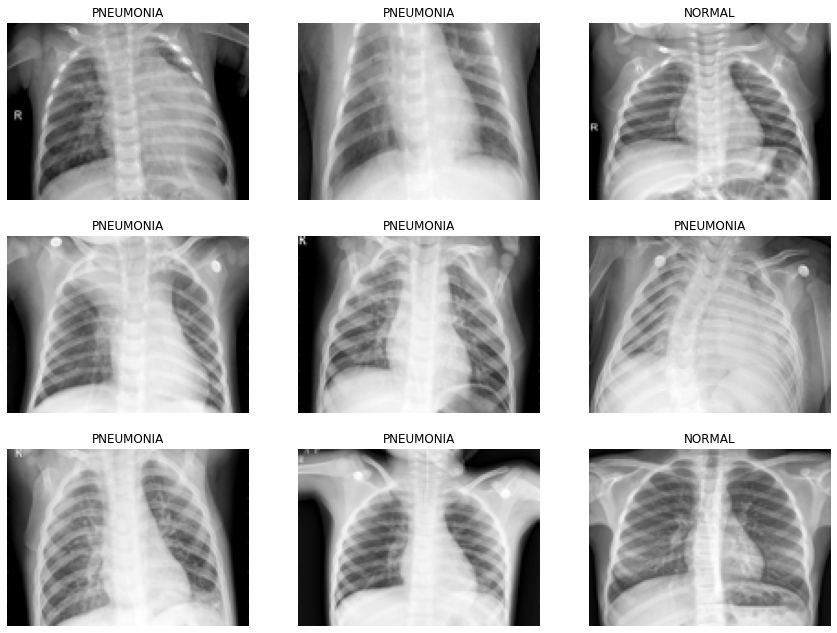

In [46]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image]);